# Prova 2

import dos módulos básicos

In [9]:
# always yielding a real result, even dividing two integers
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

# plot inline
%matplotlib inline

Carregando dados de feriados: cdi e bmf.
Fonte: [anbima](http://www.anbima.com.br/feriados/feriados.asp)

In [15]:
feriado_arq = 'feriados.xlsx'
feriado_cdi = pd.read_excel(feriado_arq,'cdi')
feriado_bmf = pd.read_excel(feriado_arq,'bmf')

In [33]:
mkt_series_arq = 'BBergValues.xlsx'
usdbrl = pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="A:E")
ptax = pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="G:H")
ibov = pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="J:M")
di1f21 = pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="O:S")
cdi = pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="U:V")
cds5y = pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="X:AB")
vol1m_off = pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="AD:AH")
vol3m_off = pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="AJ:AN")
vol12m_off = pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="AP:AT")
swpprecdi1m = pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="AV:AZ")
swpprecdi3m = pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="BB:BF")
swpprecdi12m = pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="BH:BL")
fwd1m_on = pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="BN:BR")
fwd3m_on = pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="BT:BX")
fwd12m_on = pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="BZ:CD")



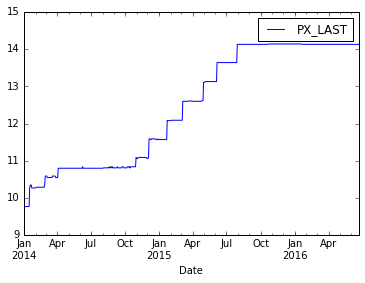

In [38]:
cdi.plot()